In [1]:
import nibabel as nib
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sin, cos
import random

from utils.plot_image import show_slices
from utils import transforms

C:\Users\user\anaconda3\envs\Synthseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


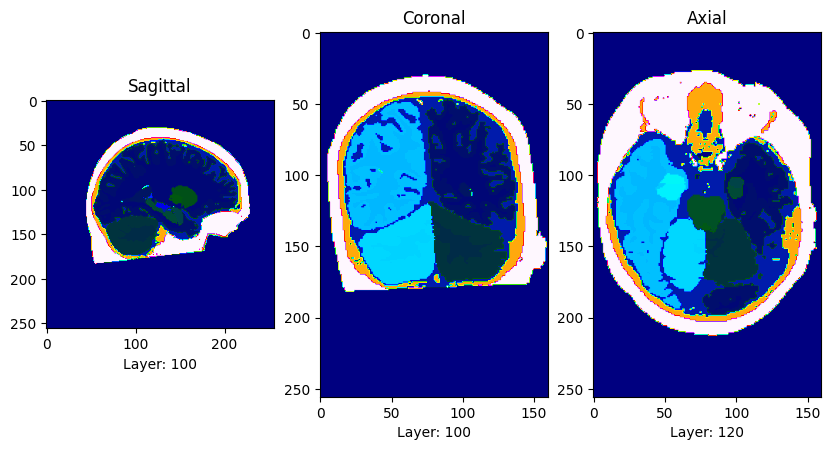

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
label = nib.load(r"nifti_files\samseg.nii.gz").get_fdata()
label = torch.from_numpy(label).float().to(device)
show_slices(label, (100, 100, 120), "gist_ncar")

# Generative Model
## Linear Deform
**Scale**

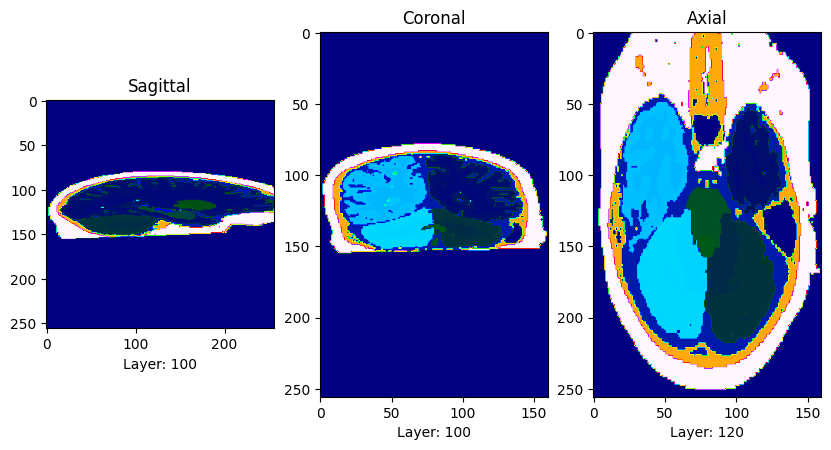

In [3]:
transform = transforms.LinearDeform(
    scales=(0.5, 0.5, 1.5, 1.5, 1, 1),
    degrees=(0, 0),
    shears=(0, 0),
    trans=(0, 0))

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

**Rotation**

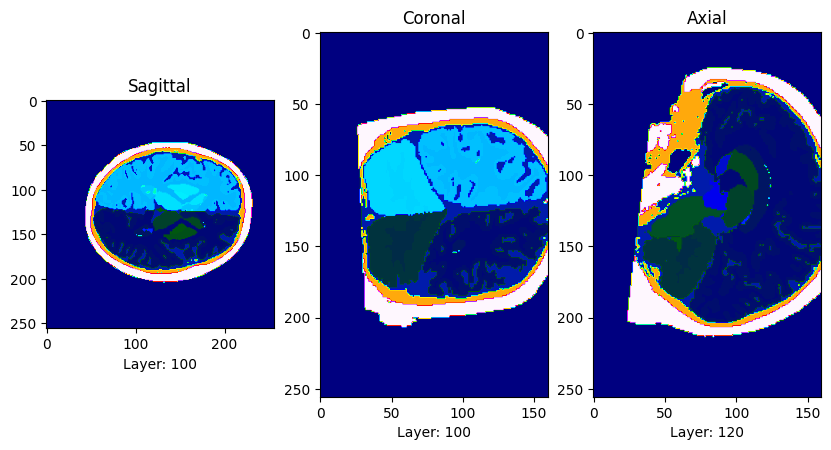

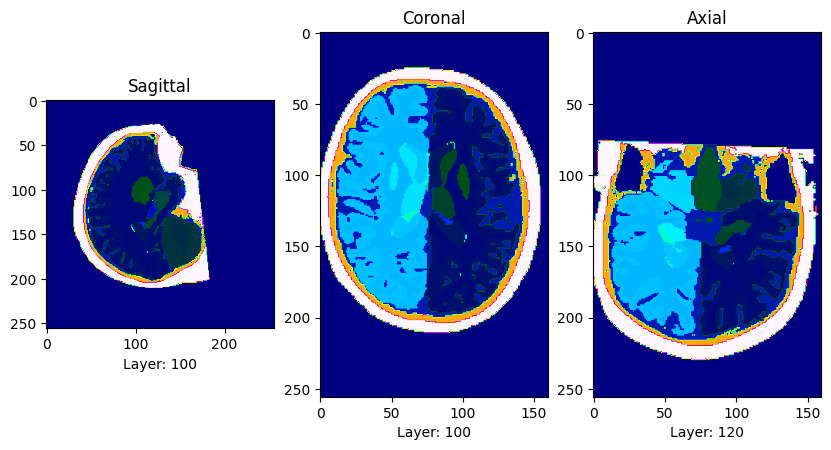

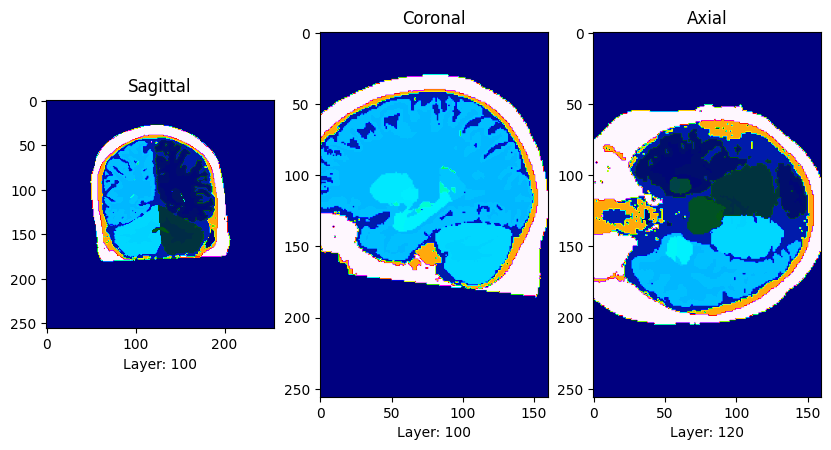

In [4]:
transform1 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(90, 90, 0, 0, 0, 0),
    shears=(0, 0),
    trans=(0, 0))

transform2 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0, 90, 90, 0, 0),
    shears=(0, 0),
    trans=(0, 0))

transform3 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0, 0, 0, 90, 90),
    shears=(0, 0),
    trans=(0, 0))

image = transform1(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform2(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform3(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

**Shear**

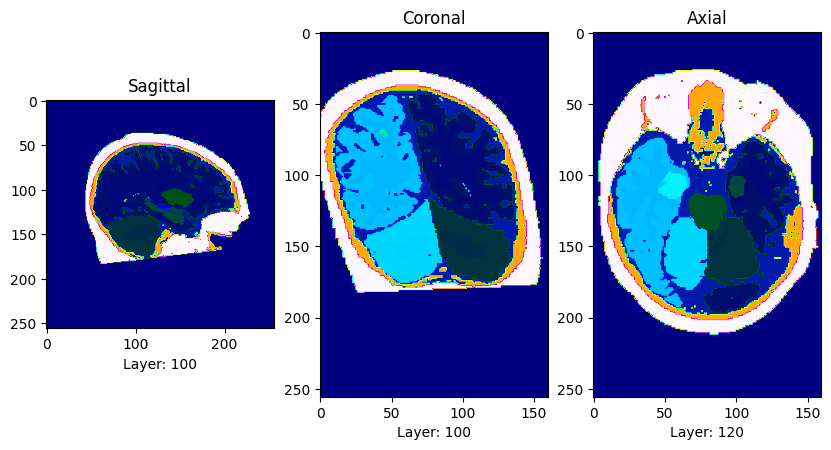

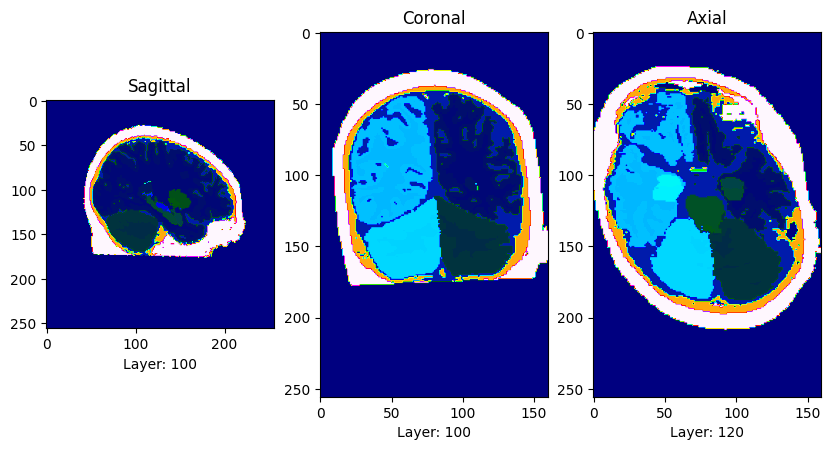

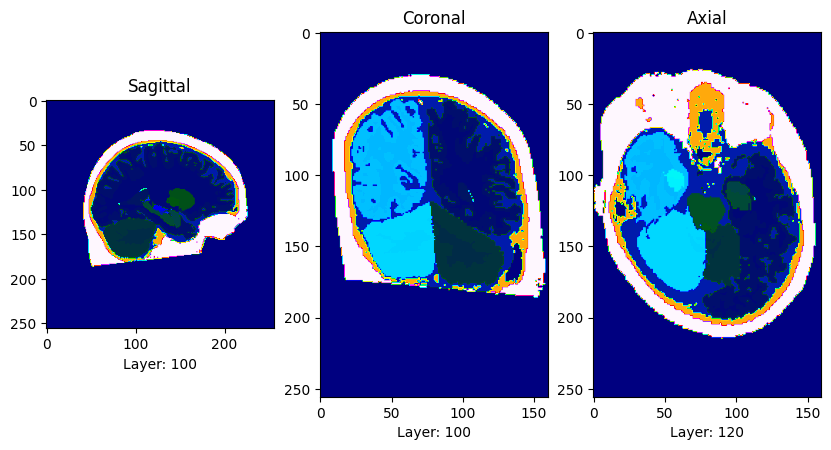

In [5]:
transform1 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0.15, 0.15, 0, 0, 0, 0),
    trans=(0, 0))

transform2 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0, 0, 0.15, 0.15, 0, 0),
    trans=(0, 0))

transform3 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0, 0, 0, 0, 0.15, 0.15),
    trans=(0, 0))

image = transform1(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform2(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform3(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

**Translation**

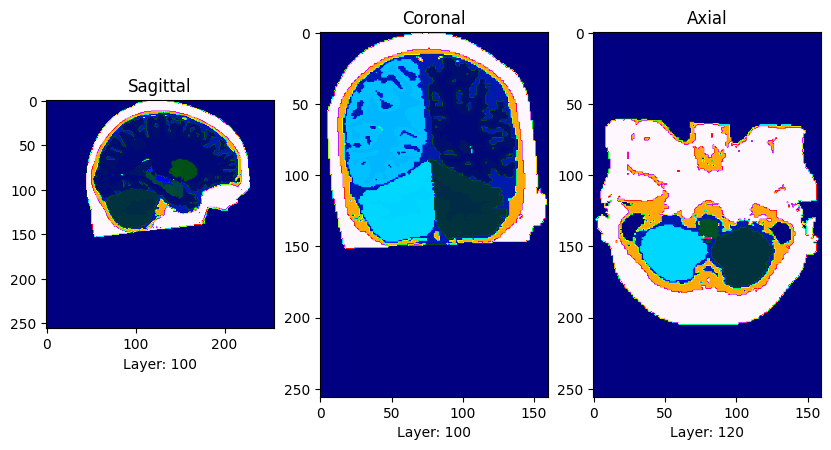

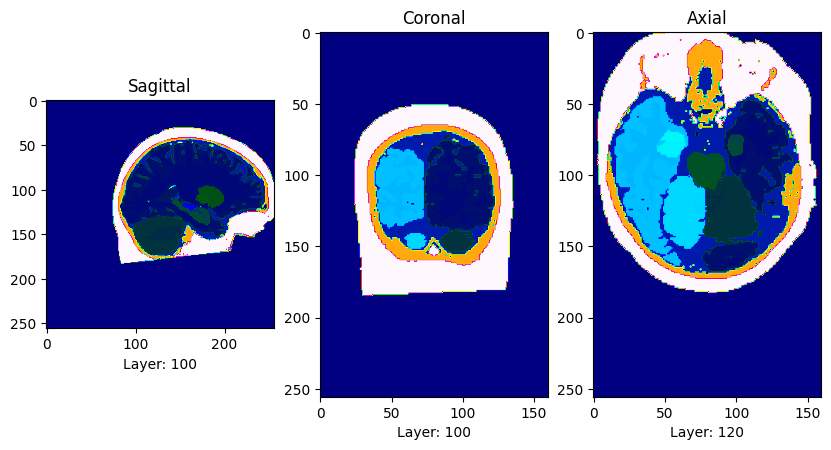

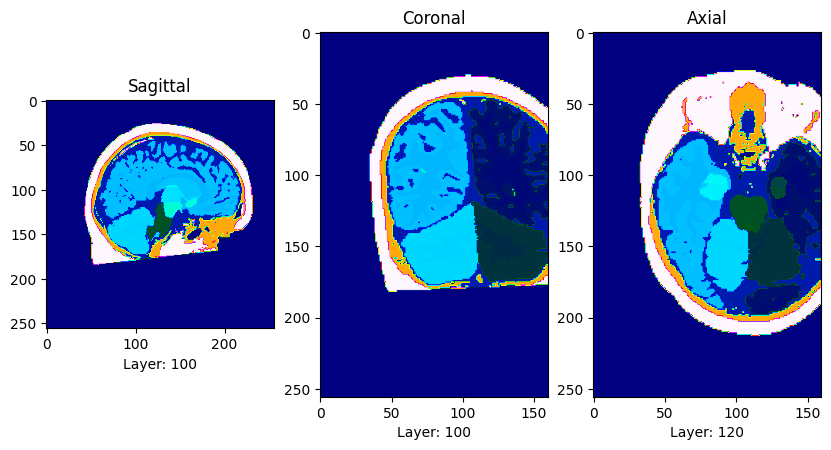

In [6]:
transform1 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0, 0),
    trans=(30, 30, 0, 0, 0, 0))

transform2 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0, 0),
    trans=(0, 0, 30, 30, 0, 0))

transform3 = transforms.LinearDeform(
    scales=(1, 1),
    degrees=(0, 0),
    shears=(0, 0),
    trans=(0, 0, 0, 0, 30, 30))

image = transform1(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform2(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

image = transform3(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

## Nonlinear Deform

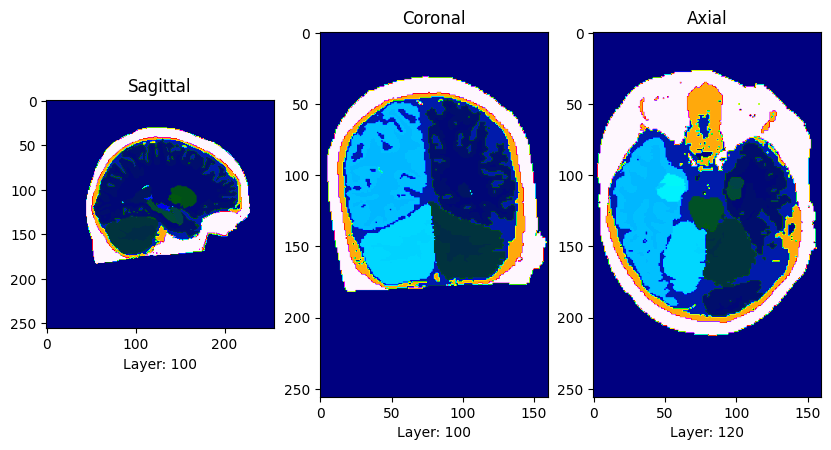

In [7]:
transform = transforms.NonlinearDeform(max_std=4)

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

## GMMSample

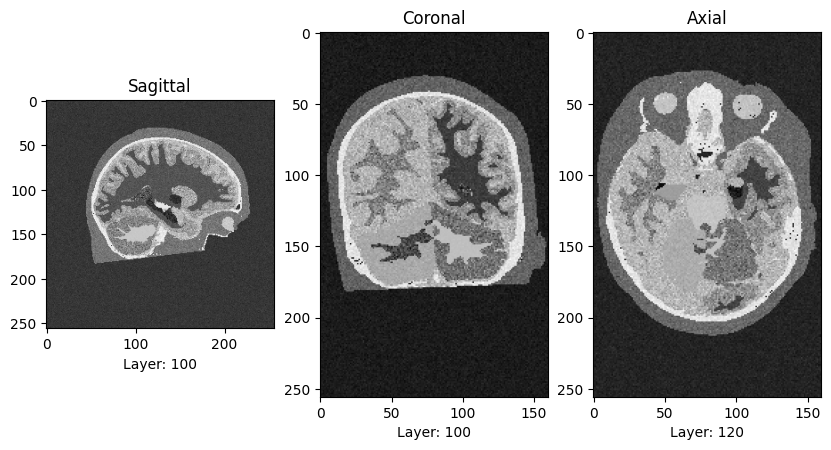

In [8]:
transform = transforms.GMMSample(mean=(0, 255), std=(0, 35))

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gray")

## RandomBiasField

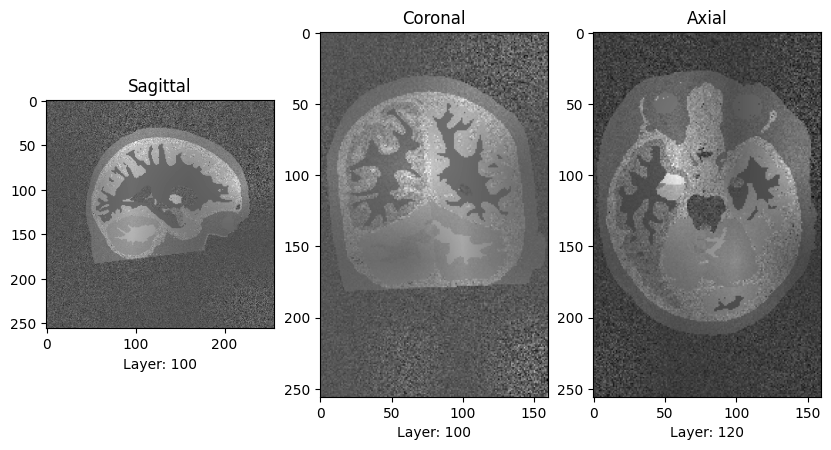

In [9]:
transform = transforms.Compose([
    transforms.GMMSample(mean=(0, 255), std=(0, 35)),
    transforms.RandomBiasField(max_std=0.6, mode='trilinear')
])

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gray")

## Rescale & GammaTransform

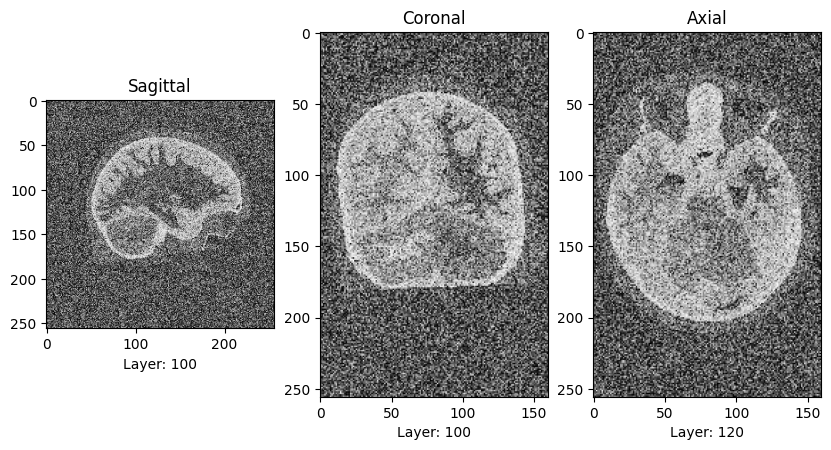

In [31]:
transform = transforms.Compose([
    transforms.GMMSample(mean=(0, 255), std=(0, 35)),
    transforms.Rescale(),
    transforms.GammaTransform()
])

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gray")

## RandomDownSample

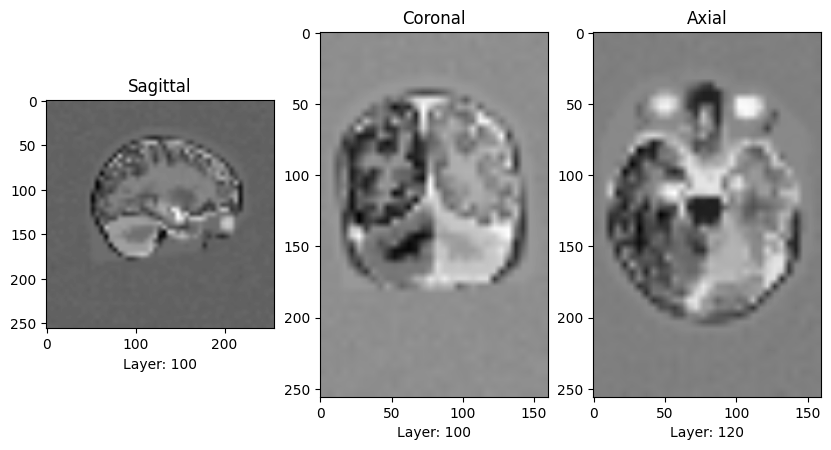

In [10]:
transform = transforms.Compose([
    transforms.GMMSample(mean=(0, 255), std=(0, 35)),
    transforms.RandomDownSample(max_slice_space=9, alpha=(0.95, 1.05), r_hr=1,)
])

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gray")

## Combine all transforms

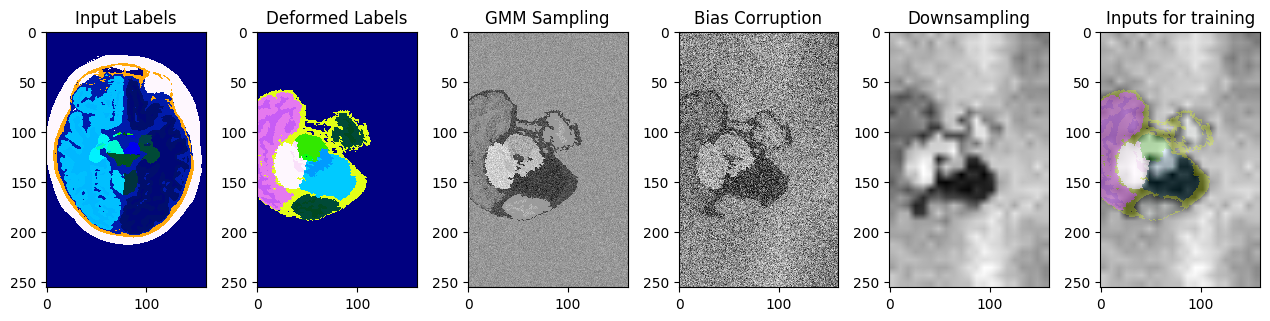

In [54]:
new_label = transforms.RandomSkullStrip()(label[None, None, ...])
new_label = transforms.LinearDeform()(new_label)
new_img = transforms.GMMSample()(new_label)
bias_img = transforms.RandomBiasField()(new_img)
bias_img = transforms.Rescale()(bias_img)
bias_img = transforms.GammaTransform(std=0.4)(bias_img)
down_img = transforms.RandomDownSample()(bias_img)

input_label = transforms.Rescale()(new_label).cpu()

layer = 130
plt.figure()
plt.subplot(161)
plt.title("Input Labels")
plt.imshow(np.rot90(label[..., layer].cpu()), cmap="gist_ncar")

plt.subplot(162)
plt.title("Deformed Labels")
plt.imshow(np.rot90(new_label[0, 0, ..., layer].cpu()), cmap="gist_ncar")

plt.subplot(163)
plt.title("GMM Sampling")
plt.imshow(np.rot90(new_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(164)
plt.title("Bias Corruption")
plt.imshow(np.rot90(bias_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(165)
plt.title("Downsampling")
plt.imshow(np.rot90(down_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(166)
plt.title("Inputs for training")
plt.imshow(np.rot90(down_img[0, 0, ..., layer].cpu()), cmap="gray")
plt.imshow(np.rot90(input_label[0, 0, ..., layer]), alpha = 1 * np.rot90(input_label[0, 0, ..., layer]), cmap="gist_ncar")

plt.tight_layout(rect=[0, 0.02, 2, 0.95])
plt.show()

#  Supplement

### torch.nn.functional.grid_sample() image isn't squre shape distortion problem

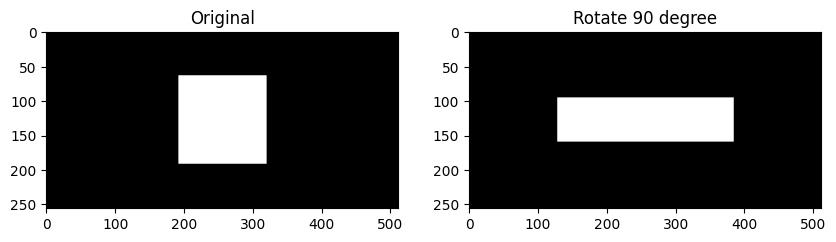

In [57]:
img = torch.zeros((256, 512))
img[64:-64, 256-64:256+64] = 1

a = math.radians(90)
affine = torch.tensor([[cos(a), -sin(a), 0],
                       [sin(a),  cos(a), 0]])[None, ...]

grid = F.affine_grid(affine, img[None, None, ...].size(), align_corners=False)
new_img = F.grid_sample(img[None, None, ...], grid, mode='nearest', align_corners=False)[0, 0, ...]
plt.figure(figsize=(10, 20))
plt.subplot(121)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.subplot(122)
plt.title("Rotate 90 degree")
plt.imshow(new_img, cmap="gray")
plt.show()

### 2D Nonlinear Deform Visualized

In [63]:
def make_grid(grid_size, gap):
    grid = torch.zeros(grid_size)
    
    for i in range(0, grid.shape[0], gap):
        grid[i, :] = 1
    for j in range(0, grid.shape[1], gap):
        grid[:, j] = 1
        
    return grid

grid_img = make_grid((256, 256), 16) # create grid image

In [70]:
# make 2D coordinate grid
x, y = torch.meshgrid(torch.linspace(-1, 1, steps=grid_img.shape[0]), torch.linspace(-1, 1, steps=grid_img.shape[1]), indexing="ij")

std_svf = random.uniform(4, 4) # sample standard deviation
svf = torch.normal(0, std_svf, (2, 10, 10)) # 10x10x10x3 simple vector field sampled from Gaussian Distribution
svf = F.interpolate(svf[None, ...], size=grid_img.size(), mode="bilinear")[0, ...] # upsample to image size
svf1 = torch.exp(svf)
svf  = svf / 256 * 2
svf1  = svf1 / 256 * 2
svf = svf.permute((1, 2, 0))
svf1 = svf1.permute((1, 2, 0))

grid = torch.stack((x, y), dim=-1).float()
grid1 = grid - svf1
grid = grid - svf
grid = grid.permute((1, 0, 2))
grid1 = grid1.permute((1, 0, 2))

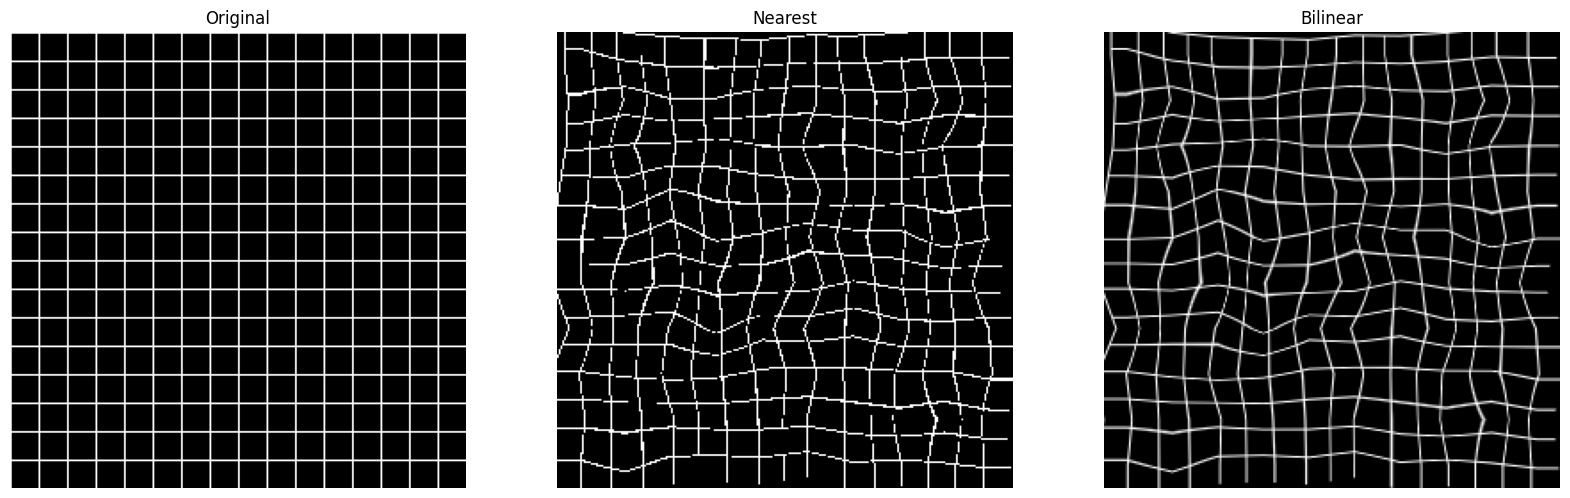

In [71]:
a = F.grid_sample(grid_img[None, None, ...], grid[None, ...], mode='nearest', align_corners=False)[0, 0, ...]
b = F.grid_sample(grid_img[None, None, ...], grid[None, ...], mode='bilinear', align_corners=False)[0, 0, ...]

cmap = "gray"
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.title("Original")
plt.imshow(grid_img, cmap=cmap)
plt.axis("off")
plt.subplot(132)
plt.title("Nearest")
plt.imshow(a, cmap=cmap)
plt.axis("off")
plt.subplot(133)
plt.title("Bilinear")
plt.imshow(b, cmap=cmap)
plt.axis("off")
plt.show()

# Training Augmentations
## RandomSkullStrip

skull strip
remove CSF


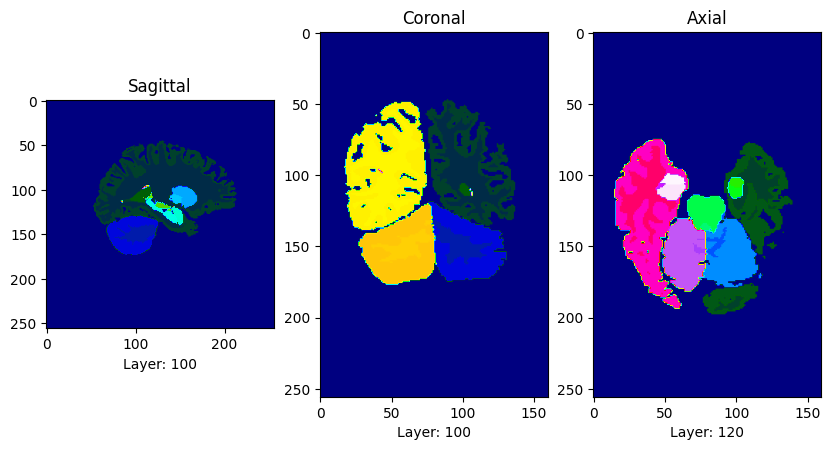

In [76]:
transform = transforms.RandomSkullStrip(verbose=True)

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

## RandomLRFlip

flip image


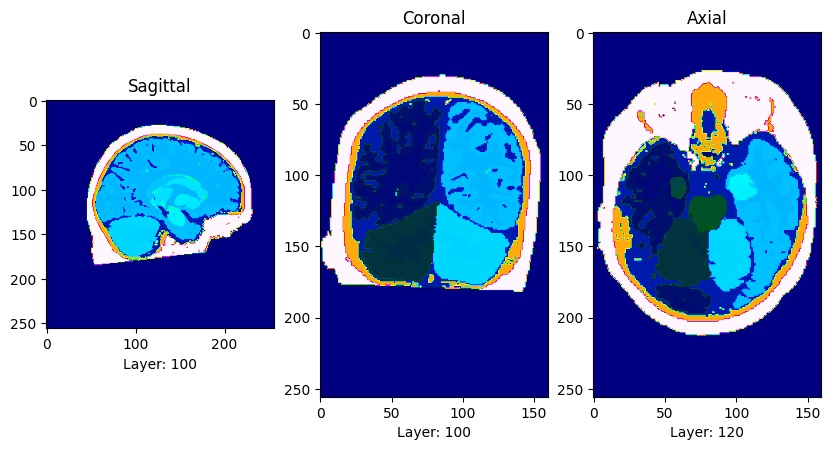

In [77]:
transform = transforms.RandomLRFlip(verbose=True)

image = transform(label[None, None, ...])[0, 0, ...].cpu()
show_slices(image, (100, 100, 120), "gist_ncar")

Output Shape: torch.Size([160, 160, 160])


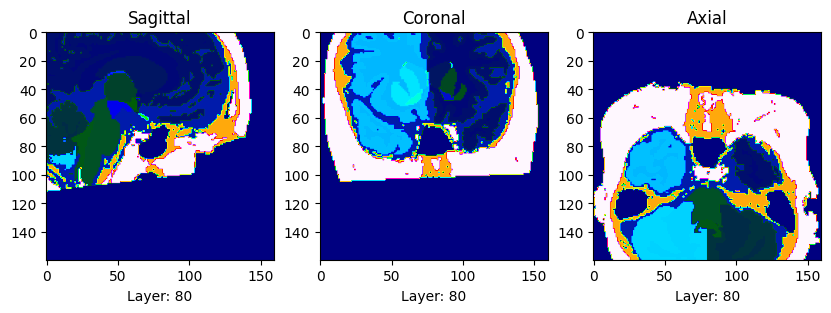

In [81]:
transform = transforms.RandomCrop(size=160)

image = transform(label[None, None, ...])[0, 0, ...].cpu()
print("Output Shape:", image.shape)
show_slices(image, (80, 80, 80), "gist_ncar")